In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import calendar
import pickle

%matplotlib inline
plt.style.use('seaborn-pastel')

import seaborn as sns
sns.set(style="whitegrid")

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [187]:
with open('pickles/appt.pickle','rb') as read_file:
    appt = pickle.load(read_file)
    
appt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71163 entries, 0 to 71958
Data columns (total 25 columns):
PatientId         71163 non-null float64
AppointmentID     71163 non-null int64
Gender            71163 non-null object
ScheduledDay      71163 non-null object
AppointmentDay    71163 non-null object
Age               71163 non-null int64
Neighbourhood     71163 non-null object
Scholarship       71163 non-null int64
Hipertension      71163 non-null int64
Diabetes          71163 non-null int64
Alcoholism        71163 non-null int64
Handcap           71163 non-null int64
SMS_received      71163 non-null int64
No_show           71163 non-null object
No_show_num       71163 non-null int64
SchedDay          71163 non-null datetime64[ns]
SchedTime         71163 non-null object
SchedDayofWeek    71163 non-null object
ApptDay           71163 non-null datetime64[ns]
ApptDayofWeek     71163 non-null object
DayDiff           71163 non-null int64
Handcap_bin       71163 non-null int64
DayDi

### EDA

0    0.717156
1    0.282844
Name: No_show_num, dtype: float64


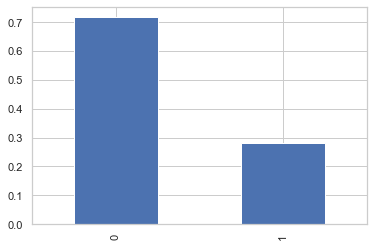

In [140]:
target_pcts = appt['No_show_num'].value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar');

/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


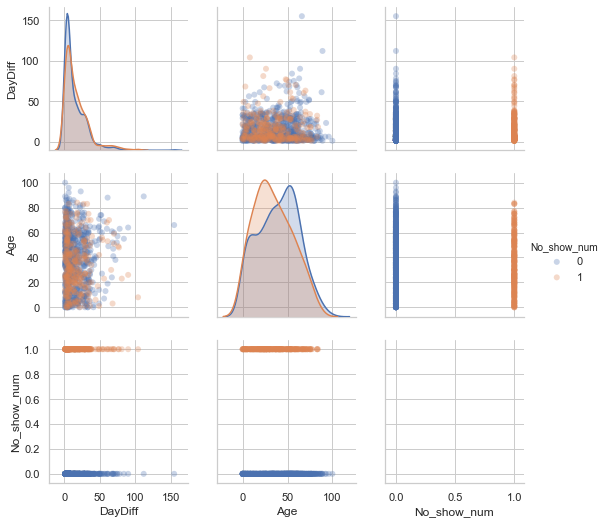

In [141]:
def plot_features(df, sample_size=500):
    
    sample = (df[['DayDiff','Age','Gender','No_show_num']].sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='No_show_num', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(appt)

### Modeling set up

In [189]:
#Set features
feature_cols = ['Gender','Age2','Neighbourhood2','Scholarship','Hipertension','Diabetes','Alcoholism',
                'Handcap_bin','SMS_received','SchedDayofWeek','ApptDayofWeek','DayDiff2']
# feature_cols = ['Gender','Age','Scholarship','Hipertension','Diabetes','Alcoholism','Handcap','SMS_received',
#                 'ApptDayofWeek','DayDiff']

a_X = appt[feature_cols]

a_X = pd.get_dummies(a_X, columns = ['Gender','Neighbourhood2','SchedDayofWeek','ApptDayofWeek'])
# a_X = pd.get_dummies(a_X, columns = ['Gender','ApptDayofWeek'],drop_first=True)

a_X.drop(columns=['Gender_F','Neighbourhood2_OTHER','SchedDayofWeek_Monday','ApptDayofWeek_Monday'],inplace=True)

X_cols = np.array(a_X.columns)
a_X.info()
a_X.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71163 entries, 0 to 71958
Data columns (total 82 columns):
Age2                                  71163 non-null int64
Scholarship                           71163 non-null int64
Hipertension                          71163 non-null int64
Diabetes                              71163 non-null int64
Alcoholism                            71163 non-null int64
Handcap_bin                           71163 non-null int64
SMS_received                          71163 non-null int64
DayDiff2                              71163 non-null int64
Gender_M                              71163 non-null uint8
Neighbourhood2_ANDORINHAS             71163 non-null uint8
Neighbourhood2_BARRO VERMELHO         71163 non-null uint8
Neighbourhood2_BELA VISTA             71163 non-null uint8
Neighbourhood2_BENTO FERREIRA         71163 non-null uint8
Neighbourhood2_BOA VISTA              71163 non-null uint8
Neighbourhood2_BONFIM                 71163 non-null uint8
Neighb

,Age2,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap_bin,SMS_received,DayDiff2,Gender_M,Neighbourhood2_ANDORINHAS,...,Neighbourhood2_VILA RUBIM,SchedDayofWeek_Friday,SchedDayofWeek_Saturday,SchedDayofWeek_Thursday,SchedDayofWeek_Tuesday,SchedDayofWeek_Wednesday,ApptDayofWeek_Friday,ApptDayofWeek_Thursday,ApptDayofWeek_Tuesday,ApptDayofWeek_Wednesday
0,76,0,1,0,0,0,0,2,0,0,...,0,0,0,0,0,1,1,0,0,0
1,23,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,1,1,0,0,0
2,39,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,1,1,0,0,0
3,19,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,1,1,0,0,0
4,30,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,1,1,0,0,0


In [190]:
#split into training and test sets
X, y = a_X, appt['No_show_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10, stratify = y)

In [191]:
y_train.value_counts()

0    38276
1    15096
Name: No_show_num, dtype: int64

In [192]:
y_test.value_counts()

0    12759
1     5032
Name: No_show_num, dtype: int64

### Basic logistic regression

In [193]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)
f1_score(lr.predict(X_test), y_test)

0.012171181782489203

In [194]:
for i in range(len(X_cols)):
    print(X_cols[i],":",lr.coef_[0][i])

Age2 : -0.008851857570334645
Scholarship : 0.23000070578835652
Hipertension : -0.12435669768641468
Diabetes : 0.11968228363672495
Alcoholism : 0.37754505134219896
Handcap_bin : 0.015709039058934646
SMS_received : -0.18285087031510922
DayDiff2 : 0.012610100045343544
Gender_M : -0.042998698717808106
Neighbourhood2_ANDORINHAS : 0.1580789191547422
Neighbourhood2_BARRO VERMELHO : 0.16603481644272405
Neighbourhood2_BELA VISTA : 0.013907112644153018
Neighbourhood2_BENTO FERREIRA : 0.0868904777269831
Neighbourhood2_BOA VISTA : -0.06585606899018295
Neighbourhood2_BONFIM : 0.06980778450908603
Neighbourhood2_CARATOÍRA : 0.15529054959813107
Neighbourhood2_CENTRO : 0.05194860335060688
Neighbourhood2_COMDUSA : -0.40194226614146794
Neighbourhood2_CONQUISTA : 0.011024534612370742
Neighbourhood2_CONSOLAÇÃO : -0.017196489903139038
Neighbourhood2_CRUZAMENTO : -0.10477367771398198
Neighbourhood2_DA PENHA : -0.04158475714221976
Neighbourhood2_DE LOURDES : -0.41296185288609
Neighbourhood2_DO CABRAL : -0.407